# Master project XENON100 LEC MAP
Cesium source

In [1]:
# Boilerplate startup code
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy
from scipy.stats import norm


In [2]:
%matplotlib inline 
matplotlib.rc('font', size=16)                   # Use big fonts...
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # ... and big plots

In [3]:
# Import the XENON100 configuration from pax
from pax.configuration import load_configuration
pax_config = load_configuration('XENON100')

In [4]:
import hax
hax.init(main_data_paths=['/home/xenon100ws/newcs']) #Folder containing the data

In [5]:
from pax import units

In [6]:
from IPython.core.display import Image

In [7]:
# Usefull minitree :
class AreaPerChannel(hax.minitrees.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['peaks.area_per_channel*', 'peaks.n_saturated_per_channel*']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        # Get the main interaction
        interaction = event.interactions[0]
        
        temp_dict = {}
        for channel, s2_area in enumerate(s2.area_per_channel):
            temp_dict['s2_area_channel_%d' % channel] = s2_area
        for channel, s1_area in enumerate(s1.area_per_channel):
            temp_dict['s1_area_channel_%d' % channel] = s1_area
            # get back: number of saturated samples per channel
        return temp_dict

In [8]:
class R2 (hax.minitrees.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
            
        # Get the main interaction
        interaction = event.interactions[0]
        
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        return dict(r2= interaction.x**2+interaction.y**2)

In [67]:
class Photopeak (hax.minitrees.TreeMaker):
    extra_branches = ['area']
    __version__ = '0.0.1' 
    
    # Cut data not in the photopeak, using cS1 and cS2_tot_bottom values determined in a other note
    # "MasterProjectCs137"
    
    def extract_data(self, event):
       
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Get the main interaction
        interaction = event.interactions[0]
            
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        event_data=dict()
        if len(event.interactions) !=0:
            if (s1.area * interaction.s1_area_correction >750) &(s1.area * interaction.s1_area_correction <1600):
                event_data['newcs1']=s1.area * interaction.s1_area_correction
            
            if ((1-s2.area_fraction_top)*interaction.s2_area_correction*s2.area) > 2.2e5:
                event_data['newcs2']=((1-s2.area_fraction_top)*interaction.s2_area_correction*s2.area)
              
        return event_data
       

# Cesium data :

In [68]:
dataset=['test_data','pax_v410_xe100_110927_1949','pax_v410_xe100_110718_1511','pax_v410_xe100_110829_1516','pax_v410_xe100_110905_1435','pax_v410_xe100_110919_1747']


In [69]:
# use hax on our data
data = hax.minitrees.load(dataset, treemakers=[Photopeak, 'Basics'], force_reload=True)
print(len(data))

Found minitree at ./test_data_Photopeak.root
Don't know a dataset named test_data, trying to find it anyway...


100%|██████████| 73000/73000 [00:09<00:00, 7812.62it/s] 


Created minitree Photopeak for dataset test_data


  0%|          | 0/50000 [00:00<?, ?it/s]

Found minitree at ./pax_v410_xe100_110927_1949_Photopeak.root
Don't know a dataset named pax_v410_xe100_110927_1949, trying to find it anyway...


100%|██████████| 50000/50000 [00:04<00:00, 10212.52it/s]


Created minitree Photopeak for dataset pax_v410_xe100_110927_1949
Found minitree at ./pax_v410_xe100_110718_1511_Photopeak.root


  0%|          | 109/50000 [00:00<00:45, 1089.84it/s]

Don't know a dataset named pax_v410_xe100_110718_1511, trying to find it anyway...


100%|██████████| 50000/50000 [00:07<00:00, 6950.50it/s]


Created minitree Photopeak for dataset pax_v410_xe100_110718_1511


  0%|          | 0/50000 [00:00<?, ?it/s]

Found minitree at ./pax_v410_xe100_110829_1516_Photopeak.root
Don't know a dataset named pax_v410_xe100_110829_1516, trying to find it anyway...


100%|██████████| 50000/50000 [00:07<00:00, 6986.94it/s]


Created minitree Photopeak for dataset pax_v410_xe100_110829_1516


  0%|          | 0/50000 [00:00<?, ?it/s]

Found minitree at ./pax_v410_xe100_110905_1435_Photopeak.root
Don't know a dataset named pax_v410_xe100_110905_1435, trying to find it anyway...


100%|██████████| 50000/50000 [00:07<00:00, 7020.70it/s]


Created minitree Photopeak for dataset pax_v410_xe100_110905_1435


  0%|          | 0/50000 [00:00<?, ?it/s]

Found minitree at ./pax_v410_xe100_110919_1747_Photopeak.root
Don't know a dataset named pax_v410_xe100_110919_1747, trying to find it anyway...


100%|██████████| 50000/50000 [00:07<00:00, 9247.10it/s]


Created minitree Photopeak for dataset pax_v410_xe100_110919_1747


  0%|          | 0/73000 [00:00<?, ?it/s]

Found minitree at ./test_data_Basics.root
Don't know a dataset named test_data, trying to find it anyway...


100%|██████████| 73000/73000 [00:27<00:00, 2677.95it/s]


Created minitree Basics for dataset test_data


  0%|          | 0/50000 [00:00<?, ?it/s]

Found minitree at ./pax_v410_xe100_110927_1949_Basics.root
Don't know a dataset named pax_v410_xe100_110927_1949, trying to find it anyway...


100%|██████████| 50000/50000 [00:14<00:00, 3336.65it/s]


Created minitree Basics for dataset pax_v410_xe100_110927_1949


  0%|          | 172/50000 [00:00<00:44, 1115.68it/s]

Found minitree at ./pax_v410_xe100_110718_1511_Basics.root
Don't know a dataset named pax_v410_xe100_110718_1511, trying to find it anyway...


100%|██████████| 50000/50000 [00:19<00:00, 2537.95it/s]


Created minitree Basics for dataset pax_v410_xe100_110718_1511


  0%|          | 140/50000 [00:00<00:38, 1307.06it/s]

Found minitree at ./pax_v410_xe100_110829_1516_Basics.root
Don't know a dataset named pax_v410_xe100_110829_1516, trying to find it anyway...


100%|██████████| 50000/50000 [00:20<00:00, 2423.57it/s]


Created minitree Basics for dataset pax_v410_xe100_110829_1516


  0%|          | 147/50000 [00:00<00:38, 1289.45it/s]

Found minitree at ./pax_v410_xe100_110905_1435_Basics.root
Don't know a dataset named pax_v410_xe100_110905_1435, trying to find it anyway...


100%|██████████| 50000/50000 [00:20<00:00, 2463.34it/s]


Created minitree Basics for dataset pax_v410_xe100_110905_1435


  0%|          | 154/50000 [00:00<00:40, 1235.89it/s]

Found minitree at ./pax_v410_xe100_110919_1747_Basics.root
Don't know a dataset named pax_v410_xe100_110919_1747, trying to find it anyway...


100%|██████████| 50000/50000 [00:20<00:00, 2450.81it/s]


Created minitree Basics for dataset pax_v410_xe100_110919_1747
323000


In [70]:
# cut data with newcs1 == nan
data= data[(data['newcs1']>0)&(data['newcs2']>0)]
print('Number of events =',len(data))

data['r']=np.sqrt(data['x']**2+data['y']**2)
data['phi']=np.arctan(data['y']/data['x'])


Number of events = 74489


In [71]:
data.head(5)

,index,newcs1,newcs2,index,cs1,cs2,dataset_number,drift_time,event_number,event_time,...,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z,r,phi
4,4,1158.293602,300753.909481,4,1158.293602,474433.255505,1.506141e+09,34694.167969,4,1434281213180883968,...,3.403345,849.740295,0.255484,344215.218750,0.366078,6.929379,-0.901130,-6.002091,6.987727,-0.129319
22,22,1098.850509,252778.134836,22,1098.850509,399090.248393,1.506141e+09,91694.945312,22,1434281213690629120,...,0.000000,1073.199097,0.160233,270263.312500,0.366614,2.641243,9.601695,-15.863226,9.958349,1.302355
26,26,1073.893754,245283.019846,26,1073.893754,400280.000367,1.506141e+09,143215.406250,26,1434281213805967872,...,0.000000,1657.052612,0.086070,261131.234375,0.387221,3.324859,-3.138418,-24.776264,4.572128,-0.756560
29,29,1147.021603,256758.503109,29,1147.021603,394679.027302,1.506141e+09,105623.382812,29,1434281213856958976,...,4.594101,1247.790649,0.145457,318191.281250,0.349450,3.449152,7.612994,-18.272846,8.357890,1.145400
39,39,1113.680358,410072.850779,39,1113.680358,654830.039940,1.506141e+09,103592.875000,39,1434281214022148096,...,37.444862,1063.908569,0.154182,326882.218750,0.373772,-0.652542,-13.144068,-17.921568,13.160256,1.521192


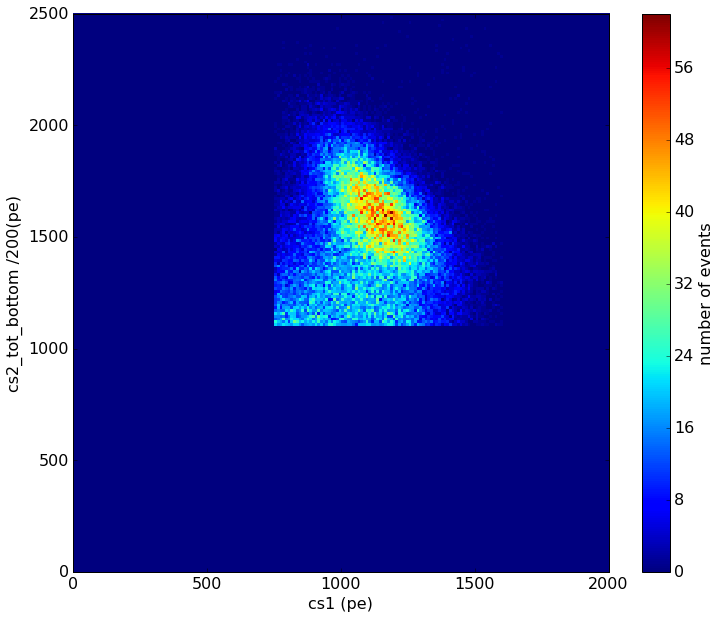

In [72]:
plt.hist2d(data['newcs1'],data['newcs2']/200, bins=200, range=[[0,2000],[0,2500]])
plt.colorbar(label='number of events')
plt.xlabel('cs1 (pe)')
plt.ylabel('cs2_tot_bottom /200(pe)')
plt.show()

In [73]:
new_cs2_tot_bottom = data['newcs2']
new_cs1 =data['newcs1']

# Combined Energy Scale (CES)
Erik's code

In [74]:
from recarray_tools import filter_on_fields, group_by, append_fields
from tqdm import tqdm
from scipy.optimize import curve_fit
from pax.formats import flat_data_formats
file_format = 'hdf5'
ioformat = flat_data_formats[file_format]()

In [75]:
# Some functions that'll be used
def func_poly_2(x,a,b,c):
    return a + b*x + c*x**2
def func_exp(x,a,tau):
    return a*np.exp(-x/tau)
def func_gauss(x,A,mu,sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

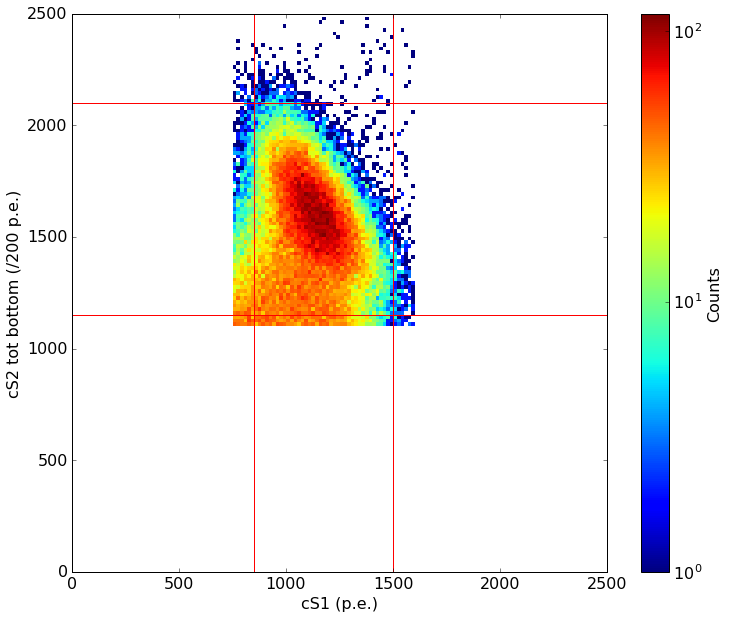

In [76]:
# We have to fit a Gaussian fonction to the ellipse in the red lines
from matplotlib.colors import LogNorm


plt.hist2d(np.array(new_cs1),np.array(new_cs2_tot_bottom)/200, bins=(150,150), range =([0,2500],[0,2500]),cmin=1,norm=LogNorm())
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 tot bottom (/200 p.e.)")
plt.axvline(850,color='red')
plt.axvline(1500,color='red')
plt.axhline(1150,color='red')
plt.axhline(2100,color='red')



plt.show()

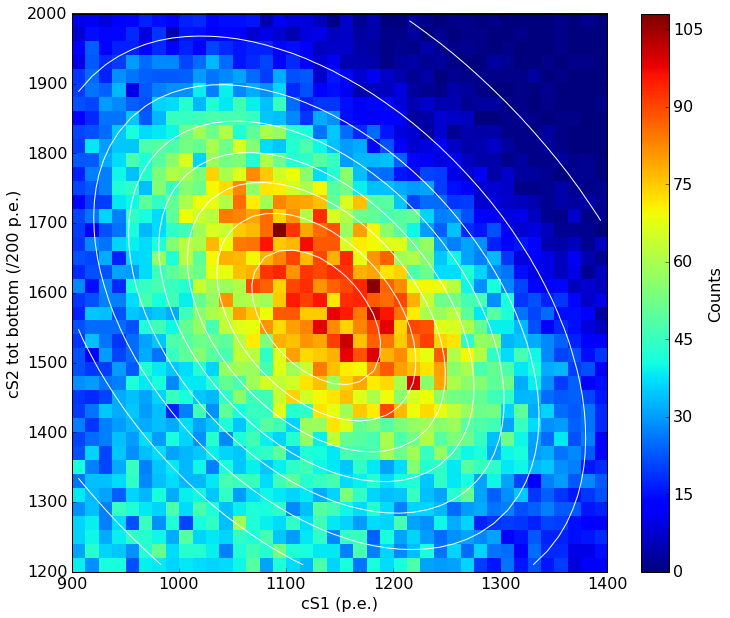

[  8.05882842e+01   1.12836189e+03   1.56509737e+03   1.11574575e+02
   2.18030255e+02  -3.59735447e-01   7.69817756e+00]


In [77]:
# Settings!
binsize = 40
range_s1 = (900,1400)
range_s2 = (1200,2000)

# This is the function to fit
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

s1s2hist = plt.hist2d(np.array(new_cs1),(np.array(new_cs2_tot_bottom)/200),
         bins=(binsize,binsize),range=(range_s1,range_s2))
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 tot bottom (/200 p.e.)")
hist_counts,hist_s1, hist_s2, _ = s1s2hist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_s1[i+1]+hist_s1[i])/2
           for i in range(len(hist_s1)-1)]
y_fit_1d =[(hist_s2[i+1]+hist_s2[i])/2
           for i in range(len(hist_s2)-1)]

x_flat = []
y_flat = []
z_flat = []

# Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
# Has been checked.

for i_y in range(len(y_fit_1d)):
    for i_x in range(len(x_fit_1d)):
        x_flat.append(x_fit_1d[i_x])
        y_flat.append(y_fit_1d[i_y])
        z_flat.append(hist_counts[i_x,i_y])
        
# twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):

initial_guess = (20,1140,1550,100,500,0.78,0)

popt, pcov = curve_fit(twoD_Gaussian, (x_flat, y_flat), z_flat, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

# For plotting purposes
data_fitted = np.array([twoD_Gaussian((x, y), *popt)
               for x in x_fit_1d
               for y in y_fit_1d]).flatten()


plt.contour(x_fit_1d, y_fit_1d, data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='w')


plt.show()

print(popt)

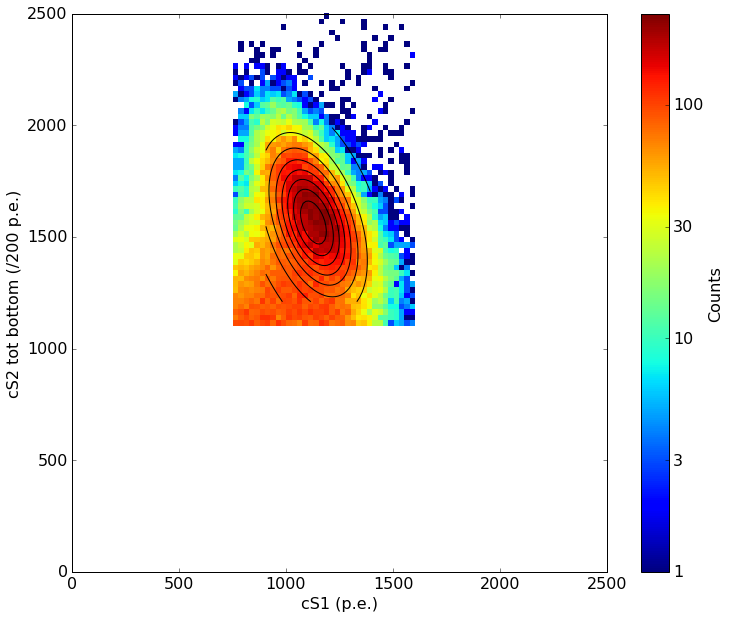

In [78]:

plt.hist2d(np.array(new_cs1),np.array(new_cs2_tot_bottom)/200,
           bins=(100,100),range=((0,2500),(0,2500)),cmin=1,norm=LogNorm())
cbar = plt.colorbar(label = 'Counts',ticks=[1,3,10,30,100])
cbar.set_ticklabels([1,3,10,30,100])
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 tot bottom (/200 p.e.)")
plt.contour(x_fit_1d, np.array(y_fit_1d), data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='black')




plt.show()

In [79]:
# We are moving to energy space!
mte1=popt[1]
mte2=popt[2]
energy_cs1= np.array(new_cs1)/popt[1]*662
energy_cs2=(np.array(new_cs2_tot_bottom)/200)/popt[2]*662
print(energy_cs1)
print(energy_cs2)

[ 679.56067376  644.6859336   630.04402484 ...,  704.21177236  600.55076621
  795.92878202]
[ 636.05974963  534.59653254  518.74523082 ...,  552.66135677  473.21401589
  508.73226587]


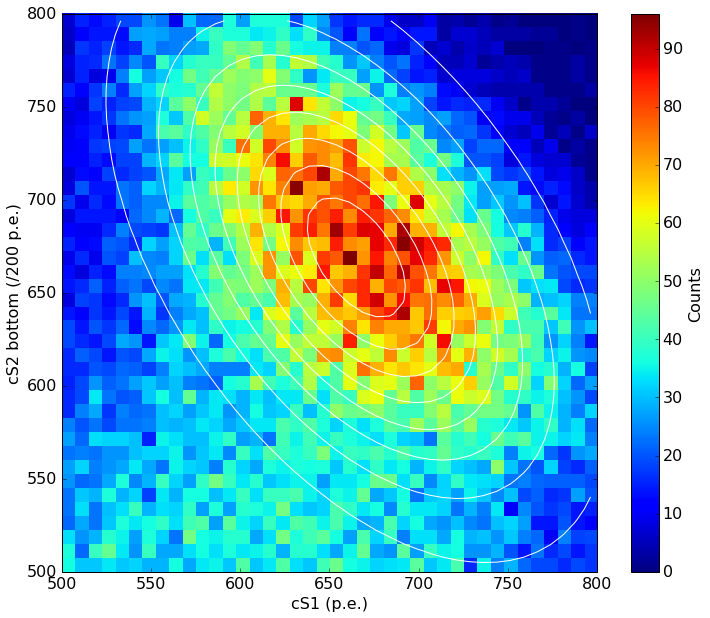

[  6.72644189e+01   6.65081624e+02   6.69023332e+02  -6.05317355e+01
  -7.08190473e+01  -5.17861421e-01   1.93844866e+01]


In [80]:
# Settings:
binsize = 40
range_s1 = (500,800)
range_s2 = (500,800)

# Better function!
def bivar(xdata_tuple, amplitude, xo,yo,sigma_x,sigma_y,rho,offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)  
    return offset + amplitude*np.exp((-1/(2*(1-rho**2)))*((x-xo)**2/(sigma_x**2) + 
                                                          (y-yo)**2/(sigma_y**2) -
                                                          2*rho*(x-xo)*(y-yo)/(sigma_x*sigma_y)) 
                                    )

s1s2hist = plt.hist2d(np.array(energy_cs1),np.array(energy_cs2), bins=(binsize,binsize),range=(range_s1,range_s2))
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 bottom (/200 p.e.)")

# hist_counts: binsize x binsize array of number of counts
# s1 / s2: binsize+1 array of edges

hist_counts,hist_s1, hist_s2, _ = s1s2hist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_s1[i+1]+hist_s1[i])/2
           for i in range(len(hist_s1)-1)]
y_fit_1d =[(hist_s2[i+1]+hist_s2[i])/2
           for i in range(len(hist_s2)-1)]

x_flat = []
y_flat = []
z_flat = []

# Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
# Has been checked.
for i_y in range(len(y_fit_1d)):
    for i_x in range(len(x_fit_1d)):
        x_flat.append(x_fit_1d[i_x])
        y_flat.append(y_fit_1d[i_y])
        z_flat.append(hist_counts[i_x,i_y])
        
# twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
initial_guess = (20,662,662,100,100,0.78,0)
popt, pcov = curve_fit(bivar, (x_flat, y_flat), z_flat, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

# For plotting purposes
data_fitted = np.array([bivar((x, y), *popt)
               for x in x_fit_1d
               for y in y_fit_1d]).flatten()


plt.contour(x_fit_1d, y_fit_1d, data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='w')



plt.show()
print(popt)


anticorrelation angle= -0.933114606823 rad


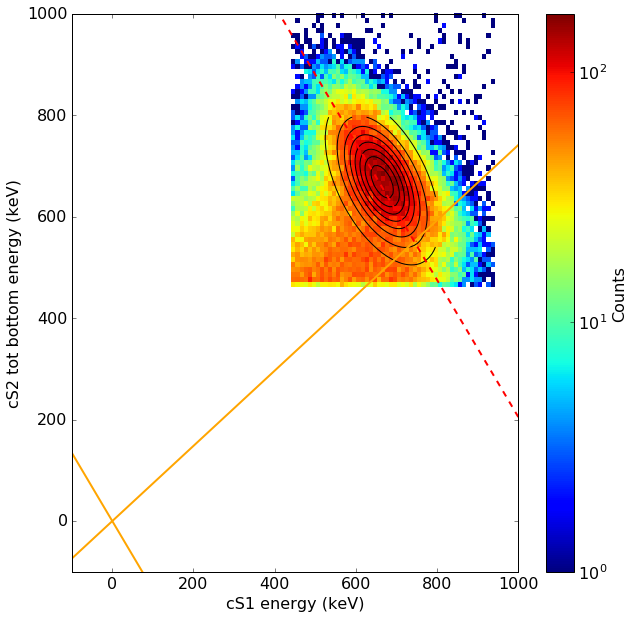

In [81]:
binsize=40
plt.figure(figsize=(10,10))
plt.hist2d(np.array(energy_cs1),np.array(energy_cs2),
           bins=(100,100),range=((0,1000),(0,1000)),cmin=1,norm=LogNorm())
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 energy (keV)")
plt.ylabel("cS2 tot bottom energy (keV)")
plt.contour(x_fit_1d, np.array(y_fit_1d), data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='black')


sigma_x  = popt[3]
sigma_y  = popt[4]
rho = popt[5]


theta=0.5*np.arctan(2*rho*(sigma_x*sigma_y)/(sigma_x**2-sigma_y**2))

theta=theta-np.pi/2 # Angle definition

print('anticorrelation angle=', theta,'rad')


x_list = [x for x in np.arange(-2000,2000,1.)]
v_axis = [-x*np.cos(theta)/np.sin(theta) for x in x_list]
u_axis = [x*np.tan(theta) for x in x_list]

c = 662.*np.cos(theta)-662.*np.sin(theta)

u_axis_2 = [x*np.tan(theta) + c/np.cos(theta) for x in x_list]
v_axis_2 = [-x*np.cos(theta)/np.sin(theta) + c/np.sin(theta) for x in x_list]

plt.plot(x_list,u_axis,color='orange',lw=2)
plt.plot(x_list,v_axis,color='orange',lw=2)
plt.plot(x_list,u_axis_2,color='red',lw=2,ls='--')

plt.xlim(-100,1000)
plt.ylim(-100,1000)


plt.show()

Projection of the energy along the large axis of the ellipse

anticorrelation angle= -0.933114606823 rad


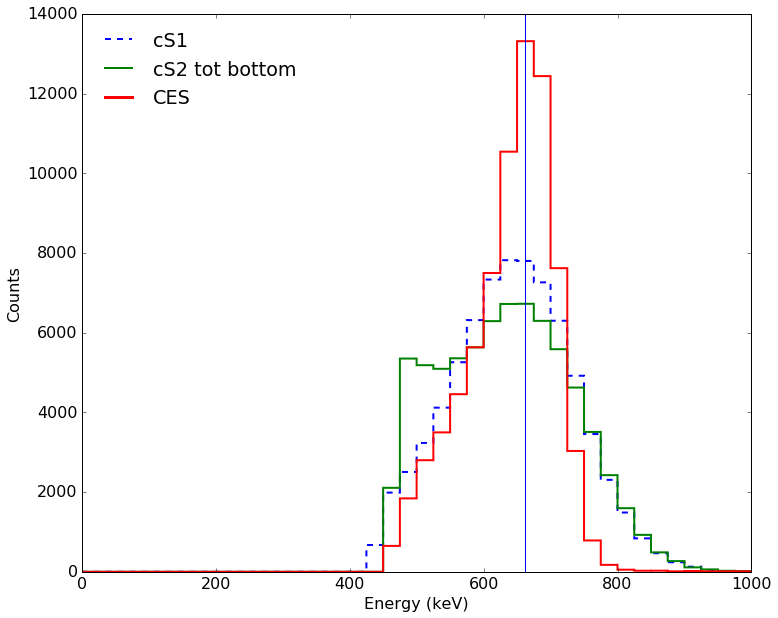

In [82]:
# http://2.bp.blogspot.com/-G-KLeae_EYU/TgdtpzntqvI/AAAAAAAABrI/Rv8Iea9zFVQ/s1600/Screen%2Bshot%2B2011-06-26%2Bat%2B1.33.51%2BPM.png

theta = 0.5*np.arctan(2*rho*(sigma_x*sigma_y)/(sigma_x**2-sigma_y**2))
theta=theta-np.pi/2 # Angle definition

print('anticorrelation angle=',theta,'rad')

# u = x cos(th) + y sin(th)
# v = y cos(th) - x sin(th)
peak_v = 662.*np.cos(theta)-662.*np.sin(theta)

# Parameters for plotting
myrange = (0,1000)
mybins = 40

# Produce histograms
plt.hist(np.array(energy_cs1),bins=mybins,histtype='step',label='cS1',range=myrange,linestyle='dashed',lw=2)
plt.hist(np.array(energy_cs2),bins=mybins,histtype='step',label='cS2 tot bottom',range=myrange,lw=2)
plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=mybins,
         histtype='step',label='CES',range=myrange,lw=2)

# Legend
p1,  = plt.plot(0,0,color='blue',linestyle='dashed',lw=2)
p2,  = plt.plot(0,0,color='green',lw=2)
p3,  = plt.plot(0,0,color='red',lw=3)
l1 = plt.legend([p1,p2,p3], ["cS1","cS2 tot bottom","CES"], loc='upper left',frameon=False)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.axvline(662)


plt.show()

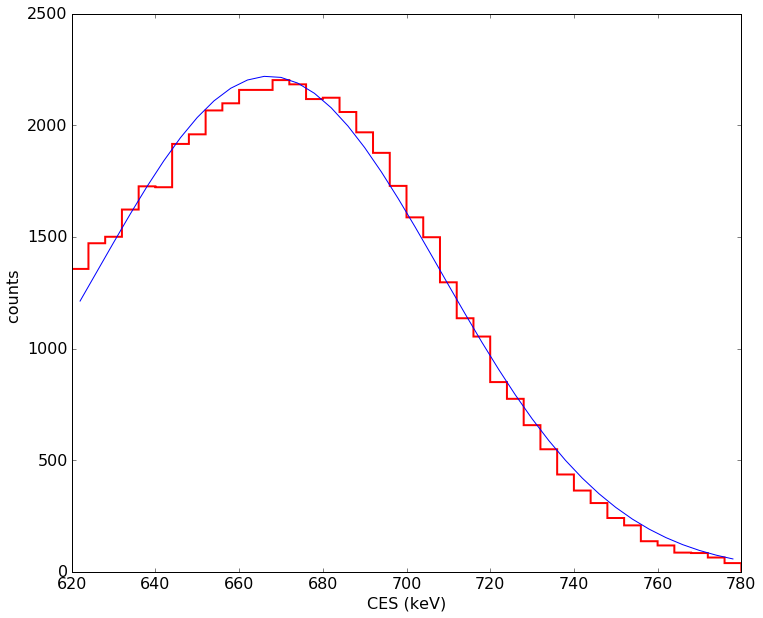

[ 2220.56826877   667.11567249   -41.02624459]
sigma_CES= -41.026244591


In [83]:
# Fit an one dimentional Gaussian function to CES to determine the standard deviation
# Settings!
binsize = 40
myrange=(620,780)
mybins=40
# This is the function to fit
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p is the initial guess

CEShist = plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=mybins,
         histtype='step',label='CES',range=myrange,lw=2, color='red')


plt.xlabel("CES (keV)")
plt.ylabel("counts ")

hist_counts,hist_energy,_=CEShist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_energy[i+1]+hist_energy[i])/2
           for i in range(0,len(hist_energy)-1)]

x_flat = []
y_flat = []


#  Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
#  Has been checked.

for i_x in range(len(x_fit_1d)):
    x_flat.append(x_fit_1d[i_x])
    y_flat.append(hist_counts[i_x])
        
#  oneD_Gaussian:

initial_guess = (400,662,100)

popt, pcov = curve_fit(gauss,x_flat, y_flat, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

#  For plotting purposes
data_fitted = np.array([gauss(x, *popt)
               for x in x_fit_1d]).flatten()

plt.plot(x_fit_1d, data_fitted.reshape(binsize,order ='F'))

plt.show()

print(popt)
sigma_CES=popt[2]
print('sigma_CES=', popt[2])

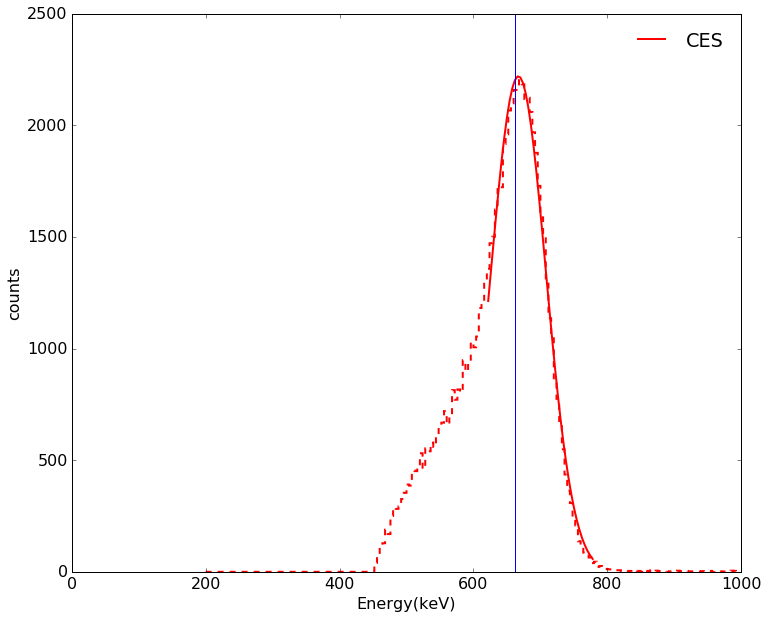

In [84]:
myrange=(200,1000)
binsize=40
plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=200,
         histtype='step',label='CES',range=myrange,lw=2, linestyle ='dashed',color='red')

plt.xlabel("Energy(keV)")
plt.ylabel("counts")
         
plt.plot(x_fit_1d, data_fitted.reshape(binsize,order ='F'),color='red', lw=2)
# Legend
p1,  = plt.plot(0,0,color='red',lw=2)

l1 = plt.legend([p1], ["CES"], loc='upper right',frameon=False)
plt.axvline (662)
# plt.axvline(662+37.7)
# plt.axvline(662-37.7)
plt.show()

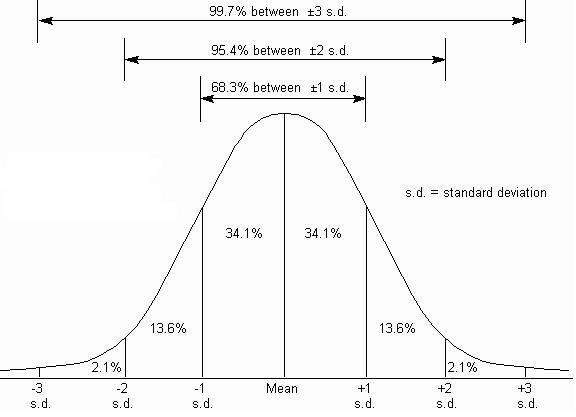

In [85]:
Image('http://www.biologyforlife.com/uploads/2/2/3/9/22392738/8058314_orig.jpg')

# Events between $\pm$ 1 $\sigma$ (68.3%)

In [86]:
CES=np.array(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)))
dataE1s=data[(CES>662+sigma_CES) & (CES<662-sigma_CES)]
CESselect1s= CES[(CES>662+sigma_CES)&(CES<662-sigma_CES)] 
len(CESselect1s)


38918

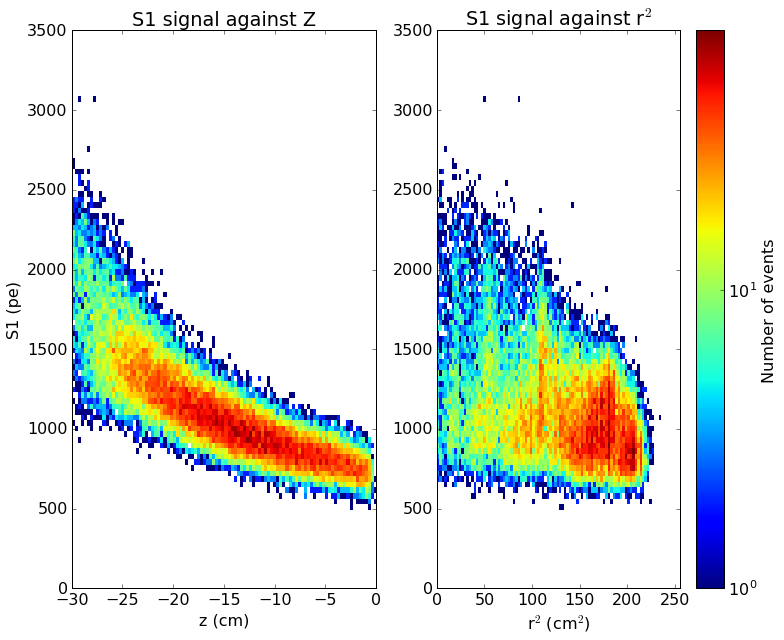

In [87]:
plt.subplot(121)
plt.hist2d(dataE1s['z'], dataE1s['s1'],range = [[-30,0],[0,3500]],
           bins=100,
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)

plt.xlabel('z (cm)')
plt.ylabel('S1 (pe)')
plt.title('S1 signal against Z')

plt.subplot(122)
plt.hist2d(dataE1s['x']**2+dataE1s['y']**2, dataE1s['s1'],range = [[0,16**2],[0,3500]],
           bins=100,
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')
plt.xlabel('r$^2$ (cm$^2$)')

plt.title('S1 signal against r$^2$')

plt.show()

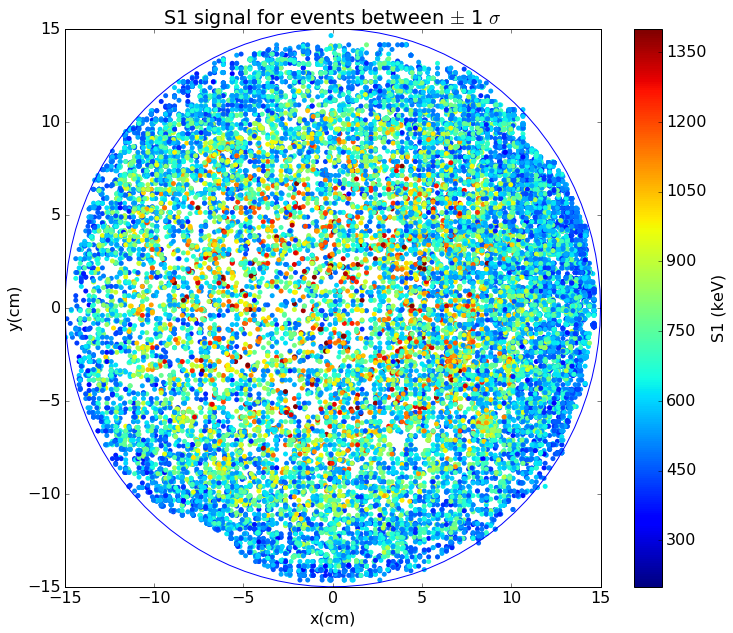

In [88]:
plt.scatter(dataE1s['x'],dataE1s['y'], c=dataE1s['s1']/mte1*662, 
            edgecolor='none', marker='.', s=100, vmin=200, vmax=1400 )
plt.xlabel('x(cm)')
plt.ylabel('y(cm)')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.colorbar(label='S1 (keV)')
theta = np.linspace(0, 2*np.pi, 100)

x = 15*np.cos(theta)
y = 15*np.sin(theta)
plt.plot(x, y)
plt.title('S1 signal for events between $\pm$ 1 $\sigma$')
plt.show()

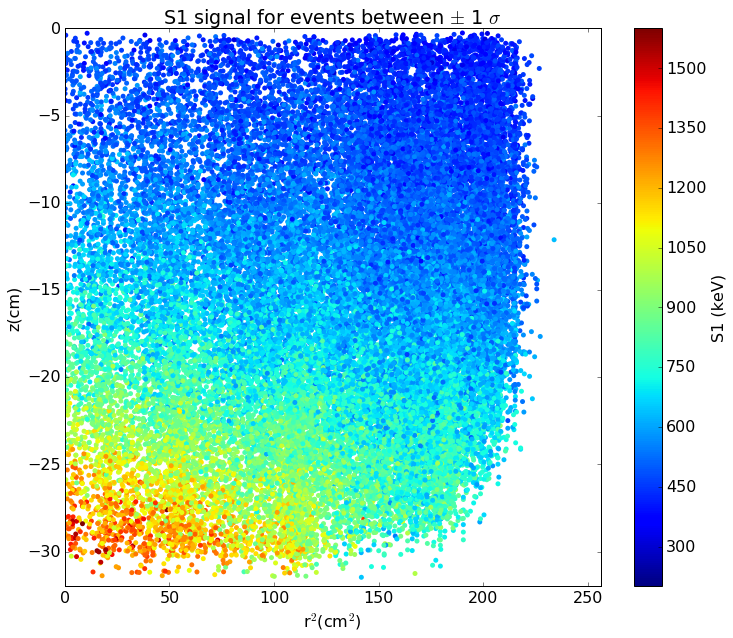

In [89]:
plt.scatter(dataE1s['x']**2+dataE1s['y']**2,dataE1s['z'], c=dataE1s['s1']/mte1*662, 
            edgecolor='none', marker='.', s=100, vmin=200, vmax=1600 )
plt.ylabel('z(cm)')
plt.xlabel('r$^2$(cm$^2$)')
plt.ylim(-32,0)
plt.xlim(0,16**2)
plt.colorbar(label='S1 (keV)')
# theta = np.linspace(0, 2*np.pi, 100)

# x = 15*np.cos(theta)
# y = 15*np.sin(theta)
# plt.plot(x, y)
plt.title('S1 signal for events between $\pm$ 1 $\sigma$')
plt.show()

Maximum of the light collection is on the center (r~0) of the TPC, on the bottom (Z~-30)

In [149]:
z_slices = np.arange(0,-32,-2)
r_slices=np.arange(0,220,14)
print(z_slices)
print(r_slices)
print(len(z_slices))
print(len(r_slices))
# z_slices and r_slices must have the same length

[  0  -2  -4  -6  -8 -10 -12 -14 -16 -18 -20 -22 -24 -26 -28 -30]
[  0  14  28  42  56  70  84  98 112 126 140 154 168 182 196 210]
16
16


In [150]:
number_list1s = []
s1_mean_values1s=[]

box_cut=[]

for i, z in enumerate(z_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=((dataE1s['z']>z_slices[i+1]) & (dataE1s['z']<z_slices[i]) &
                  ((dataE1s['r']**2 )>r_slices[j]) & ((dataE1s['r']**2)<r_slices[j+1])) 
        
        number_list1s.append(len(dataE1s[box_cut])) 
        
        s1_mean_values1s.append((np.sum(dataE1s[box_cut]['s1'])/len(dataE1s[box_cut])))
            
        if j ==(len(r_slices)-2):
            break
            
    if i == (len(z_slices)-2):
        break
       

s1_mean_values1s=np.array(s1_mean_values1s)

s1_mean_values1s=s1_mean_values1s.reshape(len(z_slices)-1,len(r_slices)-1)    

# print(s1_mean_values1s)
s1_mean_tpc1s=s1_mean_values1s[8][0] # In the middle of the TPC (z~15, r~0), values=1
print(s1_mean_values1s[8][0])

1255.18422961


225


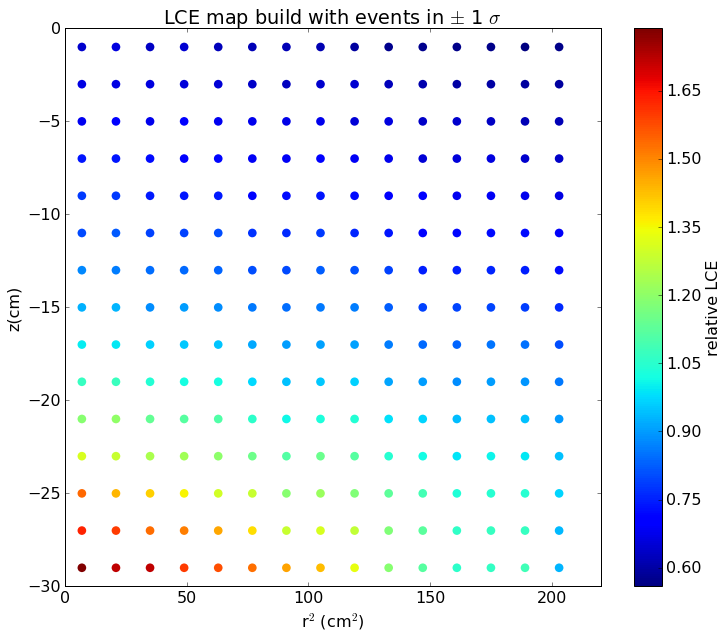

In [151]:
number_list1s = []
s1_mean_values1s=[]

box_cut=[]
ri1s=[]
zi1s=[]
for i, z in enumerate(z_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=((dataE1s['z']>z_slices[i+1]) & (dataE1s['z']<z_slices[i]) &
                  ((dataE1s['r']**2 )>r_slices[j]) & ((dataE1s['r']**2)<r_slices[j+1])) 
        
        number_list1s.append(len(dataE1s[box_cut])) 
        
        s1_mean_values1s.append((np.sum(dataE1s[box_cut]['s1']/s1_mean_tpc1s)/len(dataE1s[box_cut])))
        
        ri1s.append((r_slices[j]+r_slices[j+1])/2)
        zi1s.append((z_slices[i]+z_slices[i+1])/2)
        
        
        if j ==(len(r_slices)-2):
            break
            
    if i == (len(z_slices)-2):
        break
       

s1_mean_values1s=np.array(s1_mean_values1s)

s1_mean_values1s=s1_mean_values1s.reshape(len(r_slices)-1,len(z_slices)-1)    


result_1s=ri1s,zi1s,s1_mean_values1s

# s1_mean_values
# # plt.plot(s1_mean_values)
# # plt.show()
# print(s1_mean_values)
# print(result)
print(len(result_1s[0]))
plt.scatter(result_1s[0],result_1s[1], c=result_1s[2], edgecolor='none', s=300, marker='.')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('z(cm)')
plt.ylim(-30,0)
plt.xlim(0,220)
plt.title('LCE map build with events in $\pm$ 1 $\sigma$')
plt.show()

# Test of the LCE map in z vs r$^2$

In [152]:
LCE=result_1s[2]
print(LCE[0][1])

0.661994561975


In [153]:
# Apply the LCE to other data

dataset_test=['pax_v410_xe100_110912_1809']
data_test = hax.minitrees.load(dataset_test, treemakers=[Photopeak, 'Basics'], force_reload=True)
data_test['r']=np.sqrt(data_test['x']**2+data_test['y']**2)
data_test['phi']=np.arctan(data_test['y']/data_test['x'])
# data_test=data_test[(data_test['s1']>0)&(data_test['s2']>0)]

  0%|          | 0/50000 [00:00<?, ?it/s]

Found minitree at ./pax_v410_xe100_110912_1809_Photopeak.root
Don't know a dataset named pax_v410_xe100_110912_1809, trying to find it anyway...


100%|██████████| 50000/50000 [00:05<00:00, 8837.77it/s]


Created minitree Photopeak for dataset pax_v410_xe100_110912_1809
Found minitree at ./pax_v410_xe100_110912_1809_Basics.root


  0%|          | 134/50000 [00:00<00:37, 1323.02it/s]

Don't know a dataset named pax_v410_xe100_110912_1809, trying to find it anyway...


100%|██████████| 50000/50000 [00:20<00:00, 2421.51it/s]


Created minitree Basics for dataset pax_v410_xe100_110912_1809


In [155]:
test_cs1=[]


for k in range(0,100):
    for i, z in enumerate(z_slices):

            for j, r in enumerate(r_slices):
        
                if ((data_test['z'][k]>z_slices[i+1]) & (data_test['z'][k]<z_slices[i]) &
                    ((data_test['r'][k]**2 )>r_slices[j]) & ((data_test['r'][k]**2)<r_slices[j+1])) == True :
                        test_cs1.append(data_test['s1'][k]/LCE[i][j])
                        print('test=',data_test['s1'][k]/LCE[i][j])
                        print('cs1=',data_test['cs1'][k])
                        print('erreur(%)=', abs((data_test['s1'][k]/LCE[i][j])-data_test['cs1'][k])
                              /(data_test['cs1'][k])*100)
                        print('______')
                    
                if j ==(len(r_slices)-2):
                    break
            
            if i == (len(z_slices)-2):
                break
print(len(test_cs1))    

test= 856.322643762
cs1= 731.429381056
erreur(%)= 17.0752318598
______
test= 1066.57501216
cs1= 1015.41383202
erreur(%)= 5.03845609727
______
test= 1212.4196166
cs1= 1090.55182367
erreur(%)= 11.1748740674
______
test= 989.601382866
cs1= 893.660882127
erreur(%)= 10.7356719599
______
test= 992.877664041
cs1= 795.028810291
erreur(%)= 24.885746427
______
test= 550.670651143
cs1= 472.506422178
erreur(%)= 16.542469117
______
test= 1306.18300229
cs1= 1168.68256854
erreur(%)= 11.7654218052
______
test= 1653.18314454
cs1= 1465.27134856
erreur(%)= 12.8243684125
______
test= 826.560815888
cs1= 725.382778555
erreur(%)= 13.9482271049
______
test= 1314.68751724
cs1= 1207.15568181
erreur(%)= 8.90786806118
______
test= 983.247914942
cs1= 941.425212081
erreur(%)= 4.44248808345
______
test= 674.319330204
cs1= 631.490938563
erreur(%)= 6.78210707793
______
test= 695.953297231
cs1= 625.017658373
erreur(%)= 11.3493815587
______
test= 966.665754501
cs1= 899.199948572
erreur(%)= 7.50287030553
______
test= 470

# Events between $\pm$ 2 $\sigma$ (95.4%)

In [115]:
dataE2s=data[(CES>662+2*sigma_CES) & (CES<662-2*sigma_CES)]
CESselect2s= CES[(CES>662+2*sigma_CES)&(CES<662-2*sigma_CES)] 
len(CESselect2s)

58620

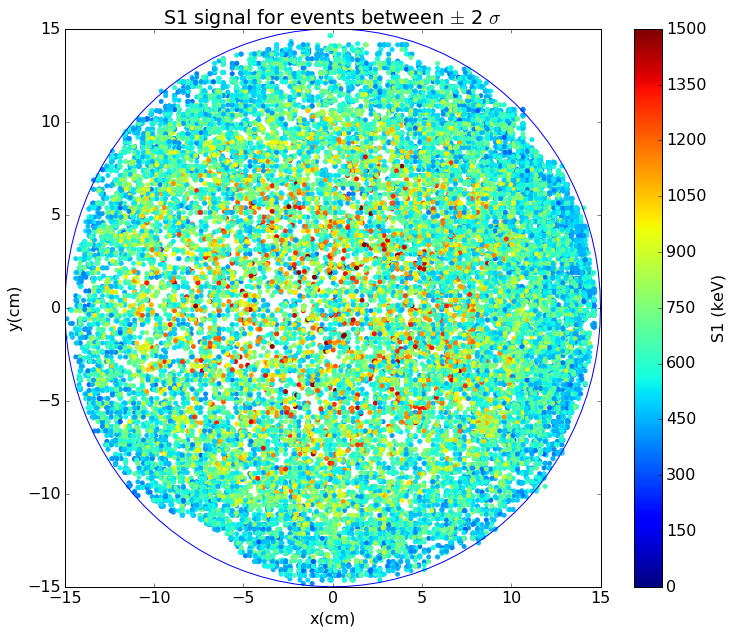

In [116]:
plt.scatter(dataE2s['x'],dataE2s['y'], c=dataE2s['s1']/mte1*662, 
            edgecolor='none', marker='.', s=100, vmin=0, vmax=1500 )
plt.xlabel('x(cm)')
plt.ylabel('y(cm)')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.colorbar(label='S1 (keV)')
theta = np.linspace(0, 2*np.pi, 100)

x = 15*np.cos(theta)
y = 15*np.sin(theta)
plt.plot(x, y)
plt.title('S1 signal for events between $\pm$ 2 $\sigma$')
plt.show()

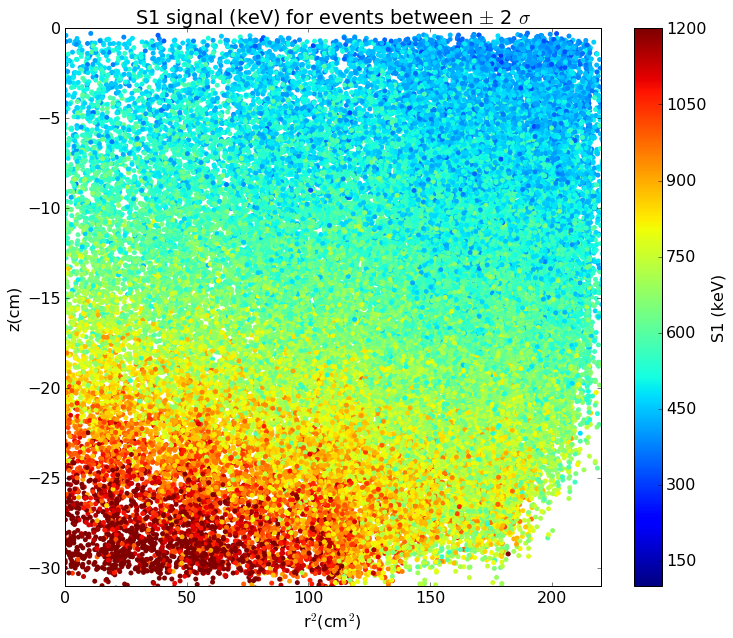

In [117]:
plt.scatter(dataE2s['x']**2+dataE2s['y']**2,dataE2s['z'], c=dataE2s['s1']/mte1*662, 
            edgecolor='none', marker='.', s=100, vmin=100, vmax=1200 )
plt.ylabel('z(cm)')
plt.xlabel('r$^2$(cm$^2$)')
plt.ylim(-31,0)
plt.xlim(0,220)
plt.colorbar(label='S1 (keV)')
    
plt.title('S1 signal (keV) for events between $\pm$ 2 $\sigma$')
plt.show()

In [118]:
z_slices = np.arange(0,-32,-2)
r_slices=np.arange(0,220,14)
print(z_slices)
print(r_slices)

[  0  -2  -4  -6  -8 -10 -12 -14 -16 -18 -20 -22 -24 -26 -28 -30]
[  0  14  28  42  56  70  84  98 112 126 140 154 168 182 196 210]


In [119]:
#example of how to do a binning (in r2 vs z)

number_list = []
s1_mean_values=[]

box_cut=[]

for i, z in enumerate(z_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=((dataE2s['z']>z_slices[i+1]) & (dataE2s['z']<z_slices[i]) &
                  ((dataE2s['r']**2 )>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        
        number_list.append(len(dataE2s[box_cut])) 
        
        s1_mean_values.append((np.sum(dataE2s[box_cut]['s1'])/len(dataE2s[box_cut])))
            
        if j ==(len(r_slices)-2):
            break
            
    if i == (len(z_slices)-2):
        break
       

s1_mean_values=np.array(s1_mean_values)

s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(z_slices)-1)    

s1_mean_values
# plt.plot(s1_mean_values)
# plt.show()
print(s1_mean_values)
s1_mean_tpc=s1_mean_values[8][0] # In the middle of the TPC (z~15, r~0), values=1
print(s1_mean_values[8][0])

[[  809.20057081   825.43744032   795.55588068   811.74624634
    788.09060567   776.98805106   784.25036554   773.1343491    756.55411318
    741.56494255   729.89860795   727.27464644   710.25431061   704.8171618
    707.21450449]
 [  842.44532776   841.99793616   833.26345792   836.39000756
    821.13204097   812.15522112   810.03212567   820.38980357
    822.64770225   793.73519117   772.21257167   775.38304028
    758.44190193   742.33229134   736.16003971]
 [  873.63327872   883.0345699    865.29450582   877.43143685
    861.25469796   848.64745845   844.3260814    856.89358748
    831.80253055   840.44947069   802.44666978   804.85235666
    794.16574827   777.43071016   768.83543006]
 [  929.21500854   915.42099086   911.11273148   908.35207688
    891.69851975   879.9818229    877.83319685   878.76471522   867.7519429
    861.88363943   833.45002252   833.21926045   835.74849365
    811.90397135   795.09017337]
 [  984.2667507    978.22896635   953.86779652   942.06944372
    

225


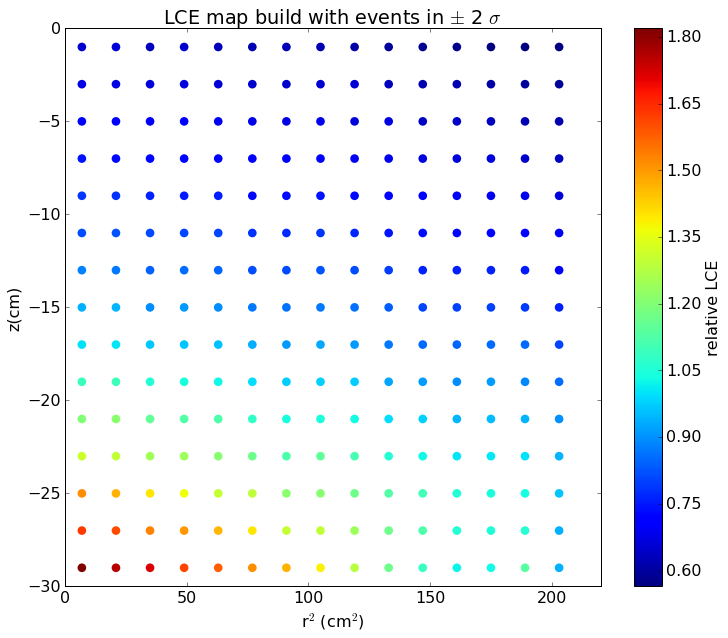

In [120]:
#example of how to do a binning (in r2 vs z)

number_list = []
s1_mean_values=[]

box_cut=[]
ri=[]
zi=[]
for i, z in enumerate(z_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=((dataE2s['z']>z_slices[i+1]) & (dataE2s['z']<z_slices[i]) &
                  ((dataE2s['r']**2 )>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        
        number_list.append(len(dataE2s[box_cut])) 
        
        s1_mean_values.append((np.sum(dataE2s[box_cut]['s1']/s1_mean_tpc)/len(dataE2s[box_cut])))
        
        ri.append((r_slices[j]+r_slices[j+1])/2)
        zi.append((z_slices[i]+z_slices[i+1])/2)
        
        
        if j ==(len(r_slices)-2):
            break
            
    if i == (len(z_slices)-2):
        break
       

s1_mean_values=np.array(s1_mean_values)

s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(z_slices)-1)    


result_2s=ri,zi,s1_mean_values

# s1_mean_values
# # plt.plot(s1_mean_values)
# # plt.show()
# print(s1_mean_values)
# print(result)
print(len(result_2s[0]))


LCE=plt.scatter(result_2s[0],result_2s[1], c=result_2s[2], edgecolor='none', s=300, marker='.')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('z(cm)')
plt.ylim(-30,0)
plt.xlim(0,220)
plt.title('LCE map build with events in $\pm$ 2 $\sigma$')
plt.show()

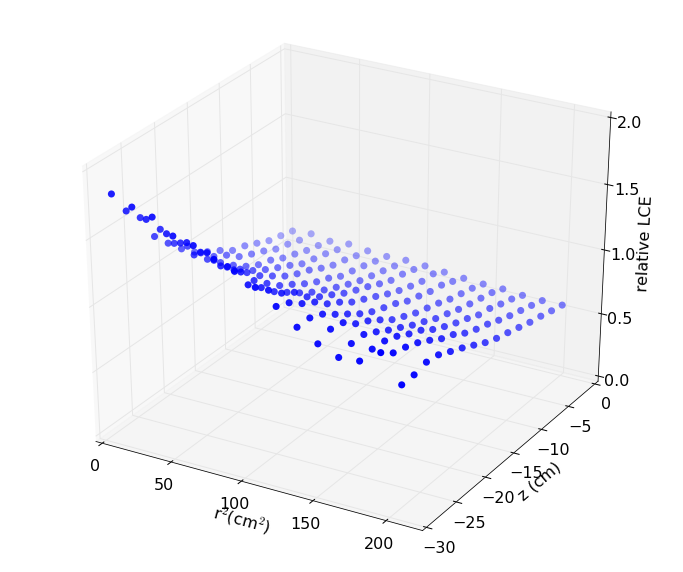

In [121]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(result_2s[0],result_2s[1], result_2s[2],
               zdir='z', s=200, marker='.', edgecolors='none',
               depthshade=True)

ax.set_zlim(0, 2)
ax.set_zlabel(' relative LCE')

ax.set_xlim(0, 220)
ax.set_xlabel(' r$^2$(cm$^2$)')

ax.set_ylabel('z (cm)')
ax.set_ylim(-30, 0)



plt.show()



# Slices in r$^2$ vs $\phi$

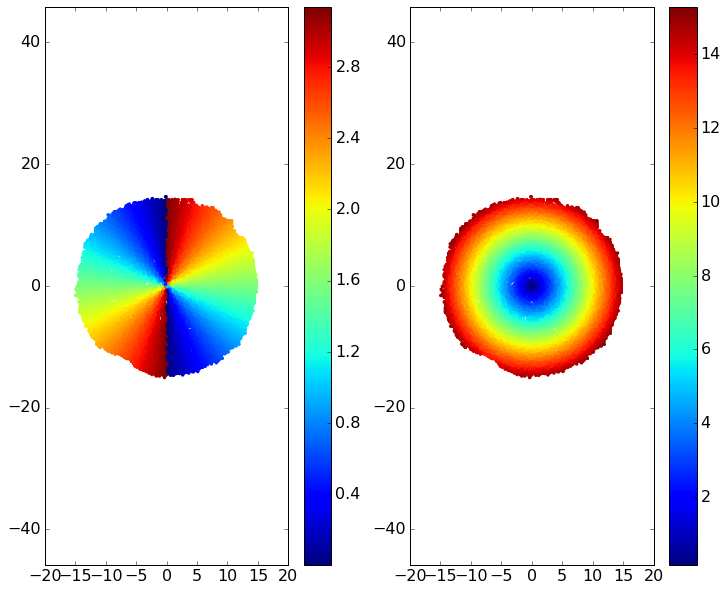

In [100]:
plt.subplot(121)
plt.scatter(dataE2s['x'], dataE2s['y'], c=dataE2s['phi']+np.pi/2,marker='.', s=50, edgecolor='none')
plt.colorbar()
plt.axis('equal')
plt.ylim(-20,20)
plt.subplot(122)
plt.scatter(dataE2s['x'], dataE2s['y'], c=dataE2s['r'],marker='.', s=50, edgecolor='none')
plt.colorbar()
plt.axis('equal')
plt.ylim(-20,20)

plt.show()

In [101]:
phi_slices = np.arange(0,3.20,0.5)
r_slices=np.arange(0,220,35)
print(len(phi_slices))
print(len(r_slices))
# phi_slices and r_slices must have the same length

7
7


In [102]:
# binning in r vs phi 

s1_mean_values2=[]
number_list2=[]

dataE2s_z=dataE2s[(dataE2s['z']>-16)&(dataE2s['z']<-14)]
# Data with -16<z<-15




for j, r in enumerate(r_slices):

    for i, phi in enumerate(phi_slices):
        
        box_cut=(((dataE2s_z['phi']+np.pi/2)>phi_slices[i]) & ((dataE2s_z['phi']+np.pi/2)<phi_slices[i+1]) &
                  ((dataE2s_z['r']**2)>r_slices[j]) & ((dataE2s_z['r']**2)<r_slices[j+1])) 
        

        number_list2.append(len(dataE2s_z[box_cut])) 
        
        s1_mean_values2.append((np.sum(dataE2s_z[box_cut]['s1'])/len(dataE2s_z[box_cut])))
    
        if i ==(len(phi_slices)-2):
            break
            
    if j == (len(r_slices)-2):
       
        break
    
# print(len(s1_mean_values2)) 

s1_mean_values2=np.array(s1_mean_values2)

s1_mean_values2=s1_mean_values2.reshape(6,6)    

# print(s1_mean_values2)
# print(number_list2)

([17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 17.5, 52.5, 87.5, 122.5, 157.5, 192.5], [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75], array([[ 0.9270211 ,  0.89940212,  0.85806344,  0.83674685,  0.80010754,
         0.78578985],
       [ 0.95484893,  0.90598054,  0.87344321,  0.88160852,  0.81912492,
         0.78478842],
       [ 0.9355096 ,  0.88741425,  0.8643925 ,  0.84980838,  0.80407159,
         0.78452362],
       [ 0.93514268,  0.88708461,  0.87185092,  0.85400665,  0.80147361,
         0.76994654],
       [ 0.94423125,  0.89452816,  0.86633525,  0.83046957,  0.8074806 ,
         0.79971087],
       [ 0.91834928,  0.92266502,  0.86606531,  0.85978616,  0.7878577

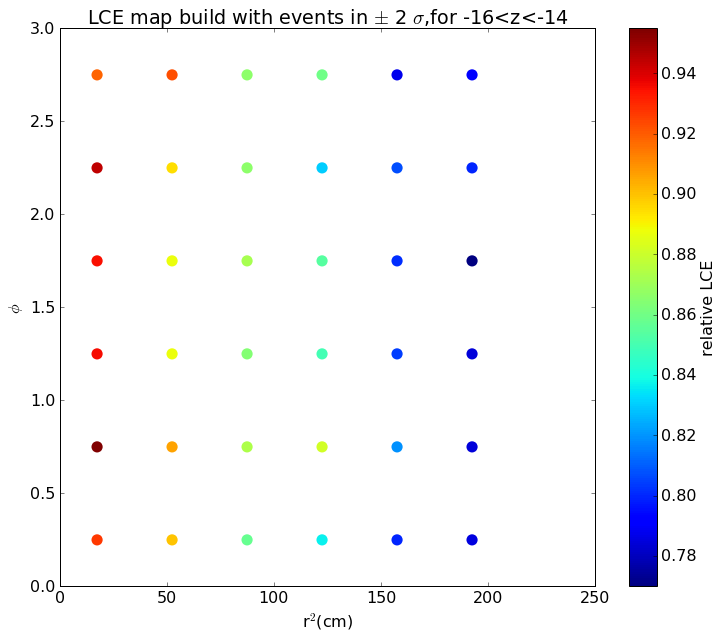

In [103]:
number_list = []
s1_mean_values=[]

box_cut=[]
ri=[]
phii=[]


for i, phi in enumerate(phi_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=(((dataE2s_z['phi']+np.pi/2)>phi_slices[i]) & ((dataE2s_z['phi']+np.pi/2)<phi_slices[i+1]) &
                  ((dataE2s_z['r']**2)>r_slices[j]) & ((dataE2s_z['r']**2)<r_slices[j+1])) 
        

        number_list.append(len(dataE2s_z[box_cut])) 
        
        s1_mean_values.append((np.sum(dataE2s_z[box_cut]['s1']/s1_mean_tpc)/len(dataE2s_z[box_cut])))
    
        ri.append((r_slices[j]+r_slices[j+1])/2)
        phii.append((phi_slices[i]+phi_slices[i+1])/2)

            
        if j == (len(r_slices)-2):
            break
    if i ==(len(phi_slices)-2):
        break
        


s1_mean_values=np.array(s1_mean_values)

s1_mean_values=s1_mean_values.reshape(6,6)    


resultphi_2s=ri,phii,s1_mean_values

# s1_mean_values
# # plt.plot(s1_mean_values)
# # plt.show()
# print(s1_mean_values)
# print(result)
print(resultphi_2s)
LCE=plt.scatter(resultphi_2s[0],resultphi_2s[1], c=resultphi_2s[2], edgecolor='none', s=500, marker='.')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$(cm)')
plt.ylabel('$\phi$')

# plt.ylim(0,3.15)
# plt.xlim(0,16)
plt.title('LCE map build with events in $\pm$ 2 $\sigma$,for -16<z<-14')
plt.show()